In [401]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default = 'warn'

log = pd.read_csv('data/data_log.csv', index_col=0)
actByInt = pd.read_csv('data/activity_by_interaction.csv', index_col=0)
actBySub = pd.read_csv('data/activity_by_subchapter.csv', index_col=0)

# Drop administrator activity
# Note: Found student event with admin type, so must also filter for admin actions
REMOVE_ADMINS = True

sid_map = {}
name_map = {}
admins = log.query('event == "admin" & act == "admin"')['sid'].unique()
# Rename chapter_activity headers to match student id (sid) in data_log
# Assuming actByInt and actBySub have same names in columns headers
for name in actByInt.columns:
    # Split over '<br>' tag and store in dictionaries
    if '<br>' in name:
        last_first = name[:name.index('<')].split(', ')
        full_name = last_first[1] + ' ' + last_first[0]
        sid = name[name.index('>') + 2:-1]
        name_map[name] = sid
        if sid not in admins or not REMOVE_ADMINS:
            sid_map[sid] = full_name

actByInt.rename(columns=name_map, inplace=True)
actBySub.rename(columns=name_map, inplace=True)

if REMOVE_ADMINS:
    log = log[log['sid'].isin(admins) == False]
    actByInt.drop(columns=admins,inplace=True)
    actBySub.drop(columns=admins, inplace=True)


# Sometimes the div_id column contains the chapter/subchapter field, so need to split and move to chapter and subchapter columns
split_div = log[log['div_id'].str.contains('Unit\\d',regex=True) & ~log['div_id'].str.contains('toctree')]

split_div['div_id'] = split_div['div_id'].str.replace('.html', '')
split_div['chapter'] = split_div['div_id'].map(lambda x : x.split('/')[0])
split_div['subchapter'] = split_div['div_id'].map(lambda x : x.split('/')[-1]) # Need to use -1 because not all unit div_id's have a '/subchapter'

log[log['div_id'].str.contains('Unit\\d',regex=True) & ~log['div_id'].str.contains('toctree')] = split_div

# Create a chapter_label_val column with float values assigned to each subchapter, in order of content progression.
log['chapter_label_val'] = log['chapter'] + '/' + log['subchapter']
log['chapter_label_val'] = log['chapter_label_val'].map(lambda x : \
                                                   float(actBySub.loc[actBySub['chapter_label'].str.contains(x),'chapter_label'].iloc[0].split(' ')[0]) \
                                                   if 'Unit' in x else np.nan)

log['timestamp'] = pd.to_datetime(log['timestamp'])
log['unit']=np.floor(log['chapter_label_val']).astype('str')


C:\Users\Nicholas\AppData\Local\Temp\ipykernel_21092\1832324888.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  split_div['div_id'] = split_div['div_id'].str.replace('.html', '')


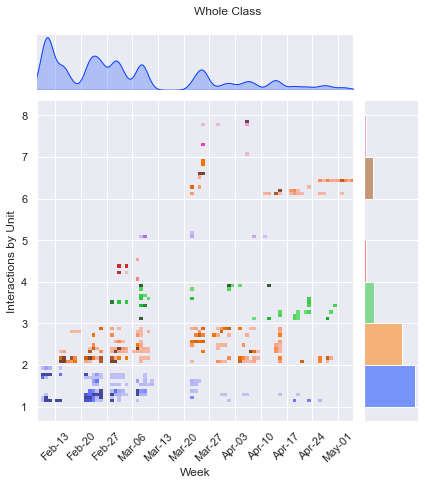

In [412]:
# Create scatterplot where x-axis is time, and y-axis represents a linear ordering of the subchapters, determined by a comparable subchapter code
# size can be constant, 1 point for each activity, for the most granular continuous view - or can cluster activities into bubbles by total interactions
# Make a joint plot with a histogram of the subchapter activity on the right to show total interaction with each subchapter
# and a day-wise histogram on top to show total activity for each day

# - Add sliders
# - Class aggregate
# - Add to FacetGrid for whole class

first_day = log['timestamp'].dt.date.min()
last_day = log['timestamp'].dt.date.max()
num_days = int((last_day - first_day).days)
num_units = len(log['unit'].dropna().unique())-1

def plot_log(name, df, save=False):
    g = sns.JointGrid()
    t, v = 'timestamp', 'chapter_label_val'

    sns.histplot(data=df, x=t, y=v, ax=g.ax_joint, bins=num_days, hue='unit', legend=False, pmax=0.5)
    sns.kdeplot(data=df, x=t, ax=g.ax_marg_x, bw_adjust=0.5, fill=True)
    sns.histplot(data=df, y=v, bins=np.arange(1,num_units+2,1), ax=g.ax_marg_y, hue='unit',legend=False)

    g.ax_joint.set_xlim(first_day,last_day)
    drange = pd.date_range(start=first_day,end=last_day,freq='1W')
    g.ax_joint.set_xticks(drange)
    g.ax_joint.set_xticklabels(drange.strftime('%b-%d'), rotation=45)
    g.ax_joint.set_xlabel('Week')

    g.ax_joint.set_ylabel('Interactions by Unit')

    # g = sns.jointplot(data=log[log['sid'] == sid], x='timestamp',y='chapter_label_val',hue='unit',kind='hist',dropna=True, \
    #           joint_kws=dict(bins=num_days), marginal_kws=dict(bins=num_days),\
    #           xlim=(first_day, last_day),ylim=(1,num_units))
    # sns.move_legend(g.ax_joint, loc='upper left')

    plt.title(name, y = 1.25, x=-2.5)
    if save: plt.savefig('output/' + name + '.png',dpi=150, bbox_inches='tight')
    plt.show()

sns.set_style('darkgrid')
sns.set_palette('bright')

# for sid in sid_map.keys():
#     plot_log(sid_map[sid], log[log['sid'] == sid].dropna())

plot_log('Whole Class', log.dropna(), save=True)
